In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/student-depression-dataset/student_depression_dataset.csv


In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc)

In [3]:
student = pd.read_csv("/kaggle/input/student-depression-dataset/student_depression_dataset.csv")
df = student.drop(columns=["id", "Gender", "Age", "City", "Profession", "Job Satisfaction", "Work Pressure", "CGPA", "Dietary Habits", "Degree"])

# 결측치 제거
filtered_df = df[~df["Sleep Duration"].isin(["Others"])]
clean_df = filtered_df[~filtered_df["Financial Stress"].isin(["?"])]
newdf = clean_df.copy(deep=True)
newdf["Sleep Duration"] = newdf["Sleep Duration"].str.replace(r'^[\'"]|[\'"]$', '', regex=True)
count = 0
what = 0
for e in newdf["Sleep Duration"]:
    if (e not in ['Less than 5 hours', '5-6 hours', '6-7 hours', '7-8 hours', 'More than 8 hours']):
        print("망함")
        what += 1
    else:
        count += 1
print(count, what)
len(newdf)
use_df = newdf

27880 0


In [4]:
# 타겟 분리
y = use_df['Depression']
X = use_df.drop(columns=['Depression'])

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(y_train.value_counts())
# 검증
print("훈련 세트 비율:")
print(y_train.value_counts(normalize=True))
print("\n테스트 세트 비율:")
print(y_test.value_counts(normalize=True))

Depression
1    13061
0     9243
Name: count, dtype: int64
훈련 세트 비율:
Depression
1    0.58559
0    0.41441
Name: proportion, dtype: float64

테스트 세트 비율:
Depression
1    0.585545
0    0.414455
Name: proportion, dtype: float64


In [5]:
# =============================================================================
# 2. 전처리 파이프라인 구성
# =============================================================================

# (1) 수치형 피처: "Academic Pressure", "Study Satisfaction", "Work/Study Hours"
numeric_features = ['Academic Pressure', 'Study Satisfaction', 'Work/Study Hours', "Financial Stress"]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# (2) 순서형 피처: "Sleep Duration"
#    순서 정의 (예: 'Less than 5 hours', '5-6 hours', '6-7 hours', '7-8 hours', 'More than 8 hours')
sleep_order = [['Less than 5 hours', '5-6 hours', '7-8 hours', 'More than 8 hours']]
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=sleep_order)),
    ('scaler', StandardScaler())
])

# (3) 범주형 피처: "Have you ever had suicidal thoughts ?", "Financial Stress", "Family History of Mental Illness"
categorical_features = ['Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop="first")) #drop="first"
])

# 컬럼별 전처리 합치기
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ord', ordinal_transformer, ['Sleep Duration']),
        ('cat', categorical_transformer, categorical_features),
        # ('text', text_transformer, text_feature)
    ]
)

# =============================================================================
# 3. 전체 파이프라인 (전처리 + SGDClassifier)
# =============================================================================
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(
        # class_weight='balanced',
        loss='log_loss',   # 로지스틱 회귀 손실 함수
        max_iter=1,
        tol=0,
        learning_rate="constant", 
        eta0=0.01, #0.01에서 높임 학습률 낮춤
        warm_start=True,
        random_state=42
        # penalty='l2',
        # alpha=0.001,
    ))
])

model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Academic Pressure',
                                                   'Study Satisfaction',
                                                   'Work/Study Hours',
                                                   'Financial Stress']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['Less '
                                                                                               'than '
                                                                                               '5 '
                                                                                               'hours',
                                                                                               '5-6 '
                                                                                               'hours',
                                                                                               '7-8 '
                                                                                               'hours',
                                                                                               'More '
                                                                                               'than '
                                                                                               '8 '
                                                                                               'hours']])),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Sleep Duration']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Have you ever had suicidal '
                                                   'thoughts ?',
                                                   'Family History of Mental '
                                                   'Illness'])])),
                ('classifier',
                 SGDClassifier(eta0=0.01, learning_rate='constant',
                               loss='log_loss', max_iter=1, random_state=42,
                               tol=0, warm_start=True))])

In [6]:
# 전처리 파이프라인만 따로 적용하고 결과 저장
X_train_preprocessed = model['preprocessor'].fit_transform(X_train)
X_test_preprocessed = model['preprocessor'].transform(X_test)

# SGDClassifier만 따로 학습 (파이프라인 밖에서)
sgd_classifier = SGDClassifier(
    class_weight={0:1.2, 1:1},  # 음성 클래스 가중치 상승,
    loss='log_loss',
    max_iter=1,
    tol=0,
    learning_rate="invscaling",
    eta0=0.01,
    warm_start=True,
    random_state=42
)
sgd_classifier

SGDClassifier(class_weight={0: 1.2, 1: 1}, eta0=0.01,
              learning_rate='invscaling', loss='log_loss', max_iter=1,
              random_state=42, tol=0, warm_start=True)

In [7]:
# ============== 다중 공선성 확인 =========
# 컬럼명 추출 (전처리 파이프라인에서)
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

# NumPy 배열 → DataFrame 변환
df_processed = pd.DataFrame(
    X_train_preprocessed,
    columns=feature_names
)
print(df_processed.head())

# VIF 계산 함수
def calculate_vif(df_processed):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_processed.columns
    vif_data["VIF"] = [variance_inflation_factor(df_processed.values, i) for i in range(df_processed.shape[1])]
    return vif_data.sort_values("VIF", ascending=False)

vif_results = calculate_vif(df_processed)
print(vif_results)

   num__Academic Pressure  num__Study Satisfaction  num__Work/Study Hours  \
0               -1.554359                -1.422359              -1.118941   
1               -0.106433                 0.045135               0.497349   
2                0.617530                -0.688612               0.766730   
3               -0.106433                 1.512630               0.766730   
4               -0.106433                 0.045135               1.305493   

   num__Financial Stress  ord__Sleep Duration  \
0              -0.095830             -1.23941   
1              -0.792955             -1.23941   
2              -0.095830              1.42531   
3               1.298421             -0.35117   
4               1.298421             -1.23941   

   cat__Have you ever had suicidal thoughts ?_Yes  \
0                                             0.0   
1                                             1.0   
2                                             1.0   
3                             

In [8]:
# 에폭별 학습
losses = []
num_epochs = 100
for epoch in range(num_epochs):
    sgd_classifier.partial_fit(X_train_preprocessed, y_train, classes=np.unique(y_train))
    y_proba = sgd_classifier.predict_proba(X_train_preprocessed)[:, 1]
    
     # log loss 계산 시 0 또는 1에 가까운 값을 방지하기 위한 클리핑
    epsilon = 1e-15
    y_proba = np.clip(y_proba, epsilon, 1 - epsilon)
    epoch_log_loss = -np.mean(y_train * np.log(y_proba) + (1 - y_train) * np.log(1 - y_proba))
    losses.append(epoch_log_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Log Loss: {epoch_log_loss:.4f}")

Epoch 1/100, Log Loss: 0.4927
Epoch 2/100, Log Loss: 0.4683
Epoch 3/100, Log Loss: 0.4559
Epoch 4/100, Log Loss: 0.4480
Epoch 5/100, Log Loss: 0.4423
Epoch 6/100, Log Loss: 0.4380
Epoch 7/100, Log Loss: 0.4346
Epoch 8/100, Log Loss: 0.4318
Epoch 9/100, Log Loss: 0.4294
Epoch 10/100, Log Loss: 0.4273
Epoch 11/100, Log Loss: 0.4255
Epoch 12/100, Log Loss: 0.4239
Epoch 13/100, Log Loss: 0.4224
Epoch 14/100, Log Loss: 0.4211
Epoch 15/100, Log Loss: 0.4199
Epoch 16/100, Log Loss: 0.4189
Epoch 17/100, Log Loss: 0.4178
Epoch 18/100, Log Loss: 0.4169
Epoch 19/100, Log Loss: 0.4160
Epoch 20/100, Log Loss: 0.4152
Epoch 21/100, Log Loss: 0.4145
Epoch 22/100, Log Loss: 0.4137
Epoch 23/100, Log Loss: 0.4131
Epoch 24/100, Log Loss: 0.4124
Epoch 25/100, Log Loss: 0.4118
Epoch 26/100, Log Loss: 0.4112
Epoch 27/100, Log Loss: 0.4106
Epoch 28/100, Log Loss: 0.4101
Epoch 29/100, Log Loss: 0.4096
Epoch 30/100, Log Loss: 0.4091
Epoch 31/100, Log Loss: 0.4087
Epoch 32/100, Log Loss: 0.4082
Epoch 33/100, Log

[Weights] [[ 1.04982461 -0.29406455  0.40814079  0.76626878 -0.1906751   1.46354707
   0.01817598]]
[Bias] [-0.48110599]


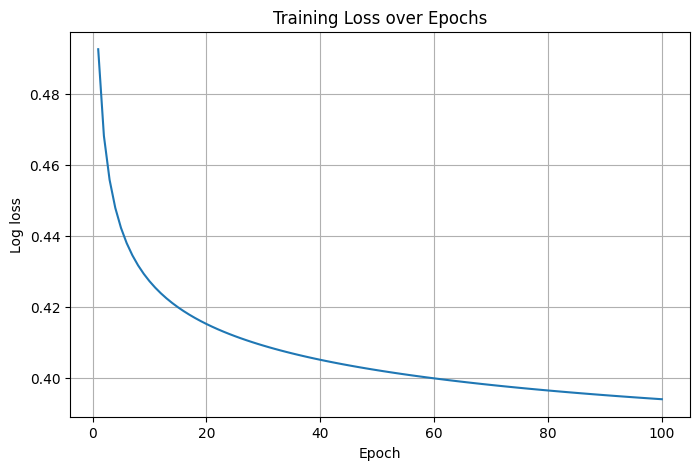

In [9]:
# weight, bias 출력
weights = sgd_classifier.coef_
bias = sgd_classifier.intercept_
print("[Weights]", weights)
print("[Bias]", bias)

# Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()

Accuracy      : 0.8303443328550932
Precision     : 0.8464296384822229
Recall        : 0.867687595712098
Specificity   : 0.7775854608394634
F1 Score      : 0.8569267997580158


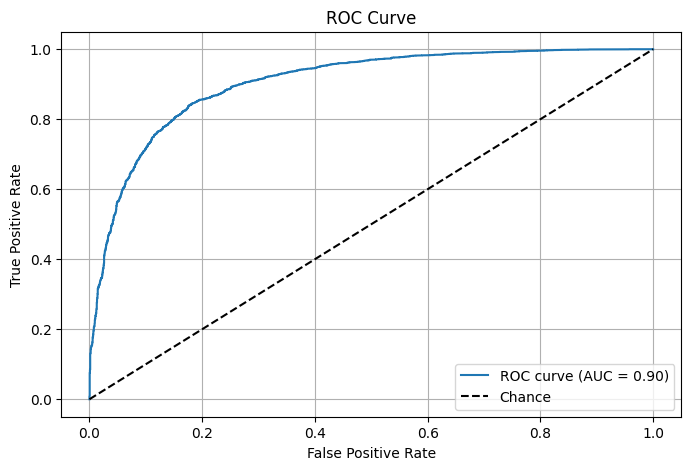

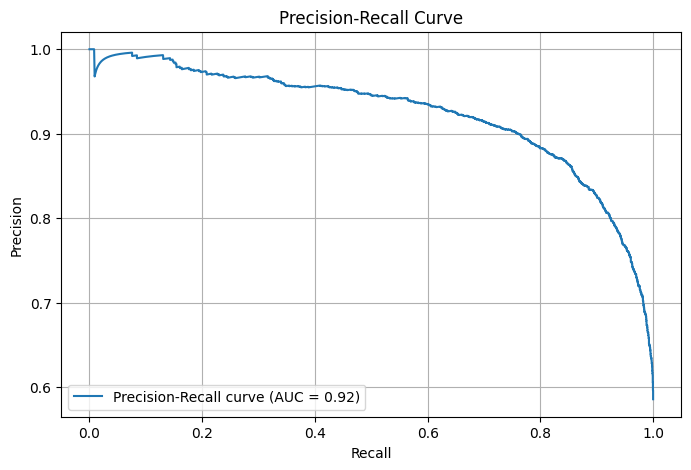

In [10]:
# 테스트 데이터에 대한 예측 및 확률 계산
y_test_pred = sgd_classifier.predict(X_test_preprocessed)
y_test_proba = sgd_classifier.predict_proba(X_test_preprocessed)[:, 1]

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Confusion Matrix를 통해 Specificity 계산: Specificity = TN / (TN + FP)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
specificity = tn / (tn + fp)

print("Accuracy      :", accuracy)
print("Precision     :", precision)
print("Recall        :", recall)
print("Specificity   :", specificity)
print("F1 Score      :", f1)

# ROC 커브 및 AUC 계산 및 시각화
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Precision-Recall 커브 및 AUC 계산 및 시각화
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_test_proba)
pr_auc = auc(recall_vals, precision_vals)

plt.figure(figsize=(8, 5))
plt.plot(recall_vals, precision_vals, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()